### Fuzzy Matching

C:\Users\perkins.watambwa\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading and preprocessing data...
Loaded 31374 records

Finding fuzzy matches (optimized version)...
Creating blocking keys...


Blocking: 100%|██████████| 25559/25559 [00:00<00:00, 978274.15it/s]


Found 37857 potential matches to evaluate


Evaluating matches: 100%|██████████| 37857/37857 [00:00<00:00, 38541.70it/s]



Found 37600 total matches (exact and fuzzy)
Results saved to: fuzzy_matches.csv

Removed 145 exact duplicates
Deduplicated dataset saved to: deduplicated_companies.csv
Exact duplicates saved to: exact_duplicates.csv

Match breakdown:
- Exact matches (100%): 145
- Fuzzy matches: 37455

=== Match Statistics ===
Total matches found: 37455
Average name similarity: 69.38%
Average address similarity: 52.10%
Average combined similarity: 60.74%

Saved similarity analysis plots to 'similarity_analysis.png'

Fuzzy matches saved to: fuzzy_only_matches.csv

Sample of fuzzy matches:
       id1    id2                                       name1  \
145   8208   8336                  Lane Engineering (pvt) Ltd   
146   5859   5860                 Goodhead Trucking (Pvt) Ltd   
147   1081  22294   ROSATI AFRICA PVT LTD (Rosati fragrances)   
148   5731   8334  Automotive Precision Engineering (pvt) Ltd   
149  26396  26397        Internet Society of Zimbabwe Chapter   

                               

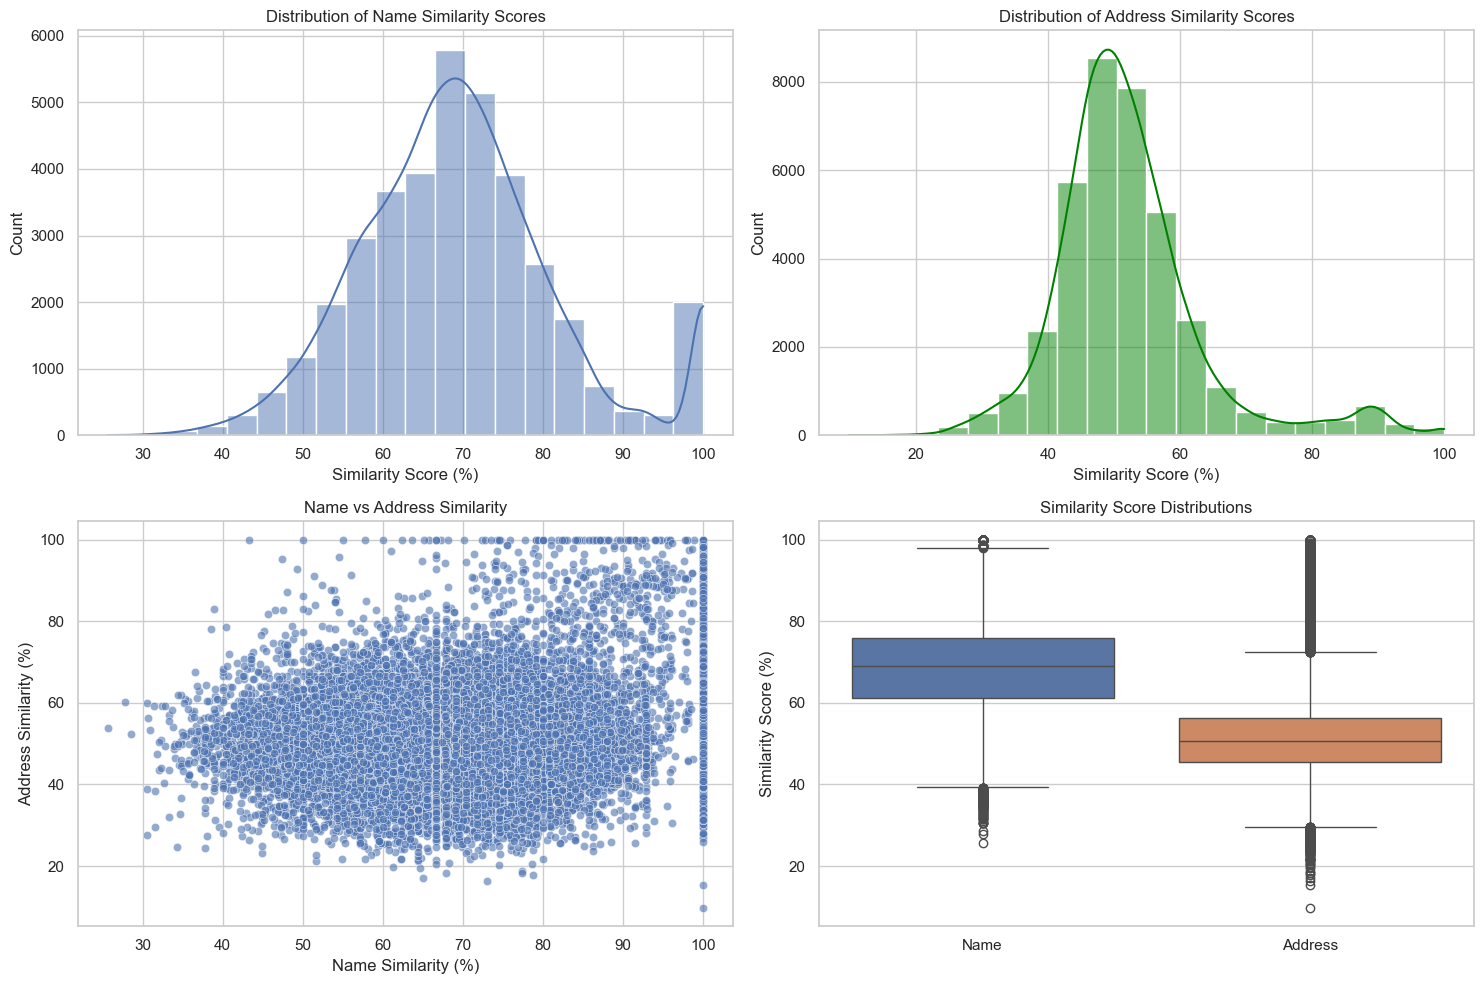

In [1]:
import pandas as pd
import numpy as np
from rapidfuzz import fuzz, process
from tqdm.auto import tqdm
import time
from collections import defaultdict
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

def preprocess_text(text):
    """Enhanced text preprocessing"""
    if pd.isna(text):
        return ""
    # Convert to string, lowercase, remove special chars, and extra whitespace
    text = str(text).lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text)  # Remove special characters
    return ' '.join(text.split())  # Normalize whitespace

def get_blocks(text, n=3):
    """Generate n-grams for blocking"""
    words = text.split()
    blocks = set()
    for i in range(len(words) - n + 1):
        blocks.add(' '.join(words[i:i+n]))
    return blocks

def analyze_matches(matches_df):
    """Generate statistics and visualizations for matches"""
    if matches_df.empty:
        print("No matches to analyze")
        return

    print("\n=== Match Statistics ===")
    print(f"Total matches found: {len(matches_df)}")
    print(f"Average name similarity: {matches_df['name_similarity'].mean():.2f}%")
    print(f"Average address similarity: {matches_df['address_similarity'].mean():.2f}%")
    print(f"Average combined similarity: {matches_df['combined_similarity'].mean():.2f}%")

    # Distribution of similarity scores
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.histplot(data=matches_df, x='name_similarity', bins=20, kde=True)
    plt.title('Distribution of Name Similarity Scores')
    plt.xlabel('Similarity Score (%)')

    plt.subplot(2, 2, 2)
    sns.histplot(data=matches_df, x='address_similarity', bins=20, kde=True, color='green')
    plt.title('Distribution of Address Similarity Scores')
    plt.xlabel('Similarity Score (%)')

    plt.subplot(2, 2, 3)
    sns.scatterplot(data=matches_df, x='name_similarity', y='address_similarity', alpha=0.6)
    plt.title('Name vs Address Similarity')
    plt.xlabel('Name Similarity (%)')
    plt.ylabel('Address Similarity (%)')

    plt.subplot(2, 2, 4)
    sns.boxplot(data=matches_df[['name_similarity', 'address_similarity']])
    plt.title('Similarity Score Distributions')
    plt.xticks([0, 1], ['Name', 'Address'])
    plt.ylabel('Similarity Score (%)')

    plt.tight_layout()
    plt.savefig('similarity_analysis.png')
    print("\nSaved similarity analysis plots to 'similarity_analysis.png'")

def find_fuzzy_matches_optimized(df, name_threshold=90, address_threshold=90):
    print("\nFinding fuzzy matches (optimized version)...")

    # Create blocking keys
    print("Creating blocking keys...")
    df['name_blocks'] = df['name_clean'].apply(lambda x: get_blocks(x) if x else set())

    # Build block index
    block_index = defaultdict(list)
    for idx, blocks in enumerate(df['name_blocks']):
        for block in blocks:
            block_index[block].append(idx)

    # Find potential matches using blocking
    potential_matches = set()
    for block, indices in tqdm(block_index.items(), desc="Blocking"):
        if len(indices) > 1:  # Only consider blocks with potential matches
            for i in range(len(indices)):
                for j in range(i+1, len(indices)):
                    id1, id2 = indices[i], indices[j]
                    if id1 != id2:
                        potential_matches.add((min(id1, id2), max(id1, id2)))

    print(f"Found {len(potential_matches)} potential matches to evaluate")

    # Find exact duplicates (100% matches) first
    exact_duplicates = set()
    fuzzy_matches = []

    for id1, id2 in tqdm(potential_matches, desc="Evaluating matches"):
        name1 = df.at[id1, 'name_clean']
        name2 = df.at[id2, 'name_clean']
        addr1 = df.at[id1, 'address_clean']
        addr2 = df.at[id2, 'address_clean']

        # Skip if either name or address is empty
        if not name1 or not name2 or not addr1 or not addr2:
            continue

        # Check for exact matches (100% on both name and address)
        if name1 == name2 and addr1 == addr2:
            exact_duplicates.add(id2)  # Mark the second occurrence for removal
            continue

        # Calculate similarity scores using rapidfuzz
        name_sim = fuzz.token_sort_ratio(name1, name2)
        addr_sim = fuzz.token_sort_ratio(addr1, addr2)
        combined_score = (name_sim + addr_sim) / 2

        # Check if either similarity meets the threshold
        if name_sim >= name_threshold or addr_sim >= address_threshold:
            fuzzy_matches.append({
                'id1': id1,
                'id2': id2,
                'name1': df.at[id1, 'name'],
                'name2': df.at[id2, 'name'],
                'address1': df.at[id1, 'address'],
                'address2': df.at[id2, 'address'],
                'name_similarity': name_sim,
                'address_similarity': addr_sim,
                'combined_similarity': combined_score,
                'match_type': 'fuzzy'
            })

    # Convert to DataFrames
    exact_dup_df = pd.DataFrame([{
        'id1': id1,
        'id2': id2,
        'name1': df.at[id1, 'name'],
        'name2': df.at[id2, 'name'],
        'address1': df.at[id1, 'address'],
        'address2': df.at[id2, 'address'],
        'name_similarity': 100.0,
        'address_similarity': 100.0,
        'combined_similarity': 100.0,
        'match_type': 'exact'
    } for id1, id2 in [(i, i) for i in exact_duplicates]]) if exact_duplicates else pd.DataFrame()

    fuzzy_matches_df = pd.DataFrame(fuzzy_matches) if fuzzy_matches else pd.DataFrame()

    # Combine exact and fuzzy matches
    all_matches = pd.concat([exact_dup_df, fuzzy_matches_df], ignore_index=True)

    return all_matches, exact_duplicates

def main_optimized():
    # Input and output file paths
    input_file = 'cleaned_companies.csv'
    output_file = 'fuzzy_matches.csv'
    deduplicated_file = 'deduplicated_companies.csv'
    exact_duplicates_file = 'exact_duplicates.csv'

    # Load and preprocess the data
    try:
        print("Loading and preprocessing data...")
        df = pd.read_csv(input_file)
        print(f"Loaded {len(df)} records")

        # Preprocess the data
        df['name_clean'] = df['name'].apply(preprocess_text)
        df['address_clean'] = df['address'].apply(preprocess_text)

    except FileNotFoundError:
        print(f"Error: Could not find the input file: {input_file}")
        print("Please make sure the file exists in the current directory.")
        return
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return

    # Set similarity thresholds (0-100)
    NAME_SIMILARITY_THRESHOLD = 0
    ADDRESS_SIMILARITY_THRESHOLD = 0

    # Find fuzzy matches and exact duplicates
    start_time = time.time()
    matches_df, exact_duplicate_indices = find_fuzzy_matches_optimized(
        df,
        name_threshold=NAME_SIMILARITY_THRESHOLD,
        address_threshold=ADDRESS_SIMILARITY_THRESHOLD
    )
    end_time = time.time()

    # Process results
    if not matches_df.empty:
        # Save all matches (exact and fuzzy)
        matches_df.to_csv(output_file, index=False)
        print(f"\nFound {len(matches_df)} total matches (exact and fuzzy)")
        print(f"Results saved to: {output_file}")

        # Create and save deduplicated dataset
        if exact_duplicate_indices:
            deduplicated_df = df.drop(index=exact_duplicate_indices).reset_index(drop=True)
            deduplicated_df.to_csv(deduplicated_file, index=False)
            print(f"\nRemoved {len(exact_duplicate_indices)} exact duplicates")
            print(f"Deduplicated dataset saved to: {deduplicated_file}")

            # Save exact duplicates for reference
            exact_duplicates = df.loc[list(exact_duplicate_indices)]
            exact_duplicates.to_csv(exact_duplicates_file, index=False)
            print(f"Exact duplicates saved to: {exact_duplicates_file}")

        # Separate exact and fuzzy matches for analysis
        exact_matches = matches_df[matches_df['match_type'] == 'exact']
        fuzzy_matches = matches_df[matches_df['match_type'] == 'fuzzy']

        print(f"\nMatch breakdown:")
        print(f"- Exact matches (100%): {len(exact_matches)}")
        print(f"- Fuzzy matches: {len(fuzzy_matches)}")

        # Generate and save analysis for fuzzy matches
        if not fuzzy_matches.empty:
            analyze_matches(fuzzy_matches)

            # Save fuzzy matches to a separate file
            fuzzy_matches_file = 'fuzzy_only_matches.csv'
            fuzzy_matches.to_csv(fuzzy_matches_file, index=False)
            print(f"\nFuzzy matches saved to: {fuzzy_matches_file}")

        # Show sample of fuzzy matches
        if not fuzzy_matches.empty:
            print("\nSample of fuzzy matches:")
            print(fuzzy_matches.head())
    else:
        print("\nNo matches found with the given thresholds.")

    print(f"\nTotal execution time: {end_time - start_time:.2f} seconds")

if __name__ == "__main__":
    main_optimized()